In [1]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense  
from keras import backend as K

import infofile
import uproot3 as uproot
import uproot3_methods.classes.TLorentzVector as LVepm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

In [314]:
samples = ["tzq", "wzjj", "wzbb", "ttz", "twz"]
#samples = ["ttz", "twz"]

frames = []

In [340]:
frames = []
for isample in range(0, len(samples)):
        frame_name = str("dframe_") + str(samples[isample] + ".csv")
        df = pd.read_csv(frame_name)
        frames.append(df)

df = pd.concat(frames)       

df.head()

,Unnamed: 0,MET,HT,ST,NJETS,NBTAGS,WMASS,TMASS,DPHIBMET,weight,label
0,0,80.821373,463.365570,349.164490,2,0,-1,-1,-1,10.45704,0.0
1,1,17.423632,562.879395,304.995544,3,1,-1,-1,-1,10.45704,0.0
2,2,72.726135,664.975281,552.042419,1,0,-1,-1,-1,10.45704,0.0
3,3,61.569218,576.815369,355.729095,2,1,-1,-1,-1,10.45704,0.0
4,4,43.451080,489.136627,341.868805,2,1,-1,-1,-1,10.45704,0.0


In [341]:
#extract features, labels, and weights
Labels=df['label']

lb = preprocessing.LabelBinarizer()
labels = lb.fit_transform(Labels)
features = df.iloc[:,1:8].astype(float)

X=features
y=np.ravel(labels)

print(y)

print("Number of signal events = " + str(np.count_nonzero(y == 1)))
print("Number of background events = " + str(np.count_nonzero(y == 0)))

weights = df['weight']
weights=np.ravel(weights) 

#weights = np.ones(len(labels))

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.05, random_state=42, shuffle=True)

# (apply final weight to each event, but give uniform weight to signal class to equalise sum of weights
#takes some manipulation!) 
df_train = pd.DataFrame()
df_train["label"] = y_train
df_train["weights"] = weights_train

sigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])
bkgSumWeights = np.sum(df_train[df_train["label"]==0]["weights"])

#equalise sum of weights for sig. and bkg.
scale = (bkgSumWeights/sigSumWeights)
df_train.loc[df_train.label==1, "weights"] *= scale

modsigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])

#print(bkgSumWeights)
#print(sigSumWeights)
#print(modsigSumWeights)

final_weights_train = df_train["weights"]

#print("final_weights_train")
#print(final_weights_train)
#hist = df.hist(bins=10)

[0 0 0 ... 1 1 1]
Number of signal events = 30000
Number of background events = 120000


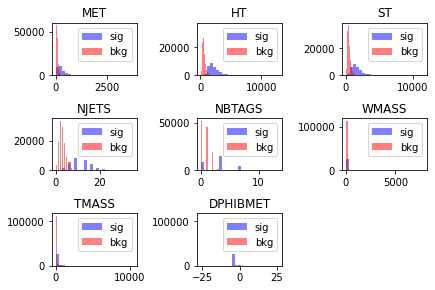

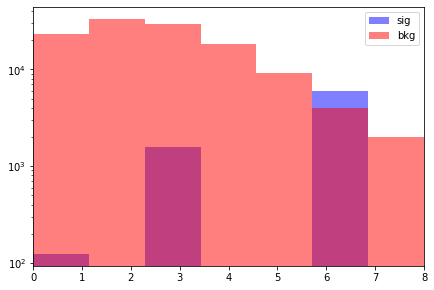

In [343]:
def sephist(col):
    yes = df[(df['label'] == 1.0)  ][col]
    no = df[(df['label']  == 0.0) ][col]
    return yes, no

vars = ['MET', 'HT', 'ST', 'NJETS', 'NBTAGS' , 'WMASS', 'TMASS', 'DPHIBMET']
for num, alpha in enumerate(vars):
    plt.subplot(3, 3, num+1)
    scale  = np.sum(sephist(alpha)[1]) / np.sum(sephist(alpha)[0])
    plt.hist((sephist(alpha)[0])*scale , bins=25, alpha=0.5, label='sig', color='b')
    plt.hist(sephist(alpha)[1], bins=25, alpha=0.5, label= 'bkg', color='r')
    plt.legend(loc='upper right')
    plt.title(alpha)
plt.tight_layout(pad=0.6, w_pad=0.8, h_pad=1.0)

#bins_jj_mass = np.linspace(-2.0, 2500.0, num=35)
bins_jj_mass = np.linspace(0.0, 8.0, num=8)

plt.figure()
scale  = (np.sum(sephist("NJETS")[1]) / np.sum(sephist("NJETS")[0]))
plt.hist((sephist("NJETS")[0])*scale, bins=bins_jj_mass, alpha=0.5, label='sig', color='b')
plt.hist(sephist("NJETS")[1], bins=bins_jj_mass, alpha=0.5, label='bkg', color='r')
plt.legend(loc='upper right')
plt.xlim([0.0, 8.0])
#plt.xlim([0.0, 2500.0])
plt.yscale('log')
plt.tight_layout(pad=0.6, w_pad=0.8, h_pad=1.0)

In [336]:
model = Sequential()
model.add(Dense(7, input_dim=7, activation='relu', kernel_regularizer=None))
model.add(Dense(14, activation='relu', kernel_regularizer=None))
model.add(Dense(28, activation='relu', kernel_regularizer=None))
model.add(Dense(28, activation='relu', kernel_regularizer=None))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

#model.compile(loss=sigLoss, optimizer='adam')   
model.fit(X_train, y_train, epochs=12,sample_weight=final_weights_train, batch_size=50, verbose=1)
model.save("twz_3l")

Epoch 1/12
2850/2850 [==============================] - 2s 689us/step - loss: 64.4289
Epoch 2/12
2850/2850 [==============================] - 2s 628us/step - loss: 58.1274
Epoch 3/12
2850/2850 [==============================] - 2s 674us/step - loss: 48.3212
Epoch 4/12
2850/2850 [==============================] - 2s 647us/step - loss: 47.3607
Epoch 5/12
2850/2850 [==============================] - 2s 658us/step - loss: 46.7830
Epoch 6/12
2850/2850 [==============================] - 2s 662us/step - loss: 46.9471
Epoch 7/12
2850/2850 [==============================] - 2s 628us/step - loss: 46.7771
Epoch 8/12
2850/2850 [==============================] - 2s 655us/step - loss: 46.5944
Epoch 9/12
2850/2850 [==============================] - 2s 626us/step - loss: 46.8066
Epoch 10/12
2850/2850 [==============================] - 2s 622us/step - loss: 46.5808
Epoch 11/12
2850/2850 [==============================] - 2s 680us/step - loss: 46.4642
Epoch 12/12
2850/2850 [=============================

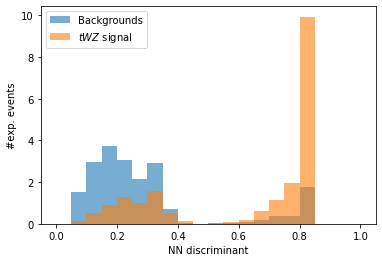

[1.         1.00001583 1.07535279 1.24570076 1.56650547 1.96811366
 2.46751989 4.0231679  4.85464067 4.90578131 4.92416923 4.97513873
 5.01685134 5.09606171 5.21859715 5.53628768 5.60204602        nan
        nan        nan]


<ipython-input-337-049c3571b6ad>:30: RuntimeWarning: invalid value encountered in true_divide
  s_over_b = selSig/selBkg


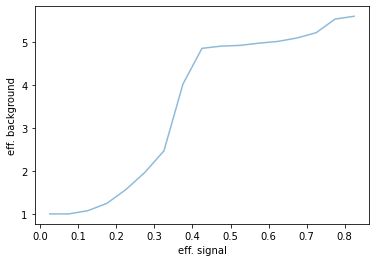

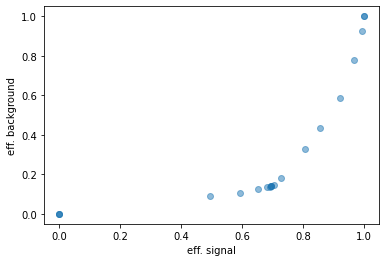

In [337]:
# plot discriminator values for "test" portion of dataset not used in training 
pred_test = model.predict(X_test)

df = pd.DataFrame()
df["labels"] = y_test
df["predictions"] = pred_test
df["weights"] = weights_test

signalVals = df[df['labels']== 1] 
backgroundVals = df[df['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")
bkgHist = plt.hist(backgroundVals["predictions"], bins=20, weights=backgroundVals["weights"],label="Backgrounds", range=[0,1], alpha=0.6, density=True)
sigHist = plt.hist(signalVals["predictions"], bins=20, weights=signalVals["weights"],  label=r"$tWZ$ signal",range=[0,1], alpha=0.6, density=True)
plt.legend()
#plt.yscale('log')
plt.show()

selBkg = np.array([])
selSig = np.array([])

for bin in range(0, len(bkgHist[0])):
    selBkg = np.append(selBkg, 1.0 - (np.sum(bkgHist[0][0:bin]) / np.sum(bkgHist[0]) ) )
    selSig = np.append(selSig,1.0 - (np.sum(sigHist[0][0:bin]) / np.sum(sigHist[0]) ) )
    #selBkg = np.sum(bkgHist[0][0:bin]) / np.sum(bkgHist[0]) 
    #selSig = np.sum(sigHist[0][0:bin]) / np.sum(sigHist[0]) 
    
s_over_b = selSig/selBkg
bincenters = np.mean(np.vstack([sigHist[1][0:-1],sigHist[1][1:]]), axis=0)

print(s_over_b)

plt.figure()
plt.plot(bincenters, s_over_b, alpha=0.5)
plt.xlabel("eff. signal")
plt.ylabel("eff. background")
plt.show()

plt.figure()
plt.scatter(selSig, selBkg, alpha=0.5)
plt.xlabel("eff. signal")
plt.ylabel("eff. background")
plt.show()
    
#df.plot.scatter(x='predictions', y='WMASS', title= "");